## This notebook treats Train & Meteo metadata

In [20]:
import pandas as pd
import  numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot') 

import warnings 
warnings.filterwarnings ('ignore') 

## Train analysis

In [2]:
# charge the training data
df_train = pd.read_csv('data/train.csv')

## Primar Analysis

In [4]:
print('Train Dataframe',df_train.shape)
df_train.head(20)

Train Dataframe (9196, 5)


,Id,week,region_code,region_name,TauxGrippe
0,5523,201152,42,ALSACE,66
1,5524,201152,72,AQUITAINE,24
2,5525,201152,83,AUVERGNE,91
3,5526,201152,25,BASSE-NORMANDIE,49
4,5527,201152,26,BOURGOGNE,33
5,5528,201152,53,BRETAGNE,50
6,5529,201152,24,CENTRE,30
7,5530,201152,21,CHAMPAGNE-ARDENNE,13
8,5531,201152,94,CORSE,19
9,5532,201152,43,FRANCHE-COMTE,20


Columns

- Id - an unique id for each entry in both files
- week - the week number of a specific year - format YYYYWW - e.g. 201402 correspond to the second week of 2014 and 201531 for the 31st week of 2015,
- region_code - the INSEE number and the of the French Region - e.g. 31 is NORD-PAS-DE-CALAIS,
- region_name - name of the French region,
- TauxGrippe - Influenza rate per 100,000 population - Since this corresponds to the quantity to predict, this data field is only in the train.csv file.

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9196 entries, 0 to 9195
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Id           9196 non-null   int64 
 1   week         9196 non-null   int64 
 2   region_code  9196 non-null   int64 
 3   region_name  9196 non-null   object
 4   TauxGrippe   9196 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 359.3+ KB


## Missing Values Check

In [ ]:
# check for missing values
df_train.isna().sum()

In [6]:
df_train[df_train['TauxGrippe'] < 0]

,Id,week,region_code,region_name,TauxGrippe


No missing values & no negative flu rate found.

In [7]:
# check for duplicate entries based on 'region_code' and 'week'
df_train.duplicated(subset=['region_code', 'week']).sum()

np.int64(0)

No duplicates found.

## Descriptive Stats

In [8]:
df_train['week'].describe()

count      9196.000000
mean     200776.148325
std         229.790090
min      200401.000000
25%      200552.000000
50%      200776.500000
75%      200953.000000
max      201152.000000
Name: week, dtype: float64

## Unique Values Check

In [9]:
# check number of unique weeks
df_train['week'].nunique()

418

In [10]:
df_train['region_code'].nunique()

22

## EDA Train

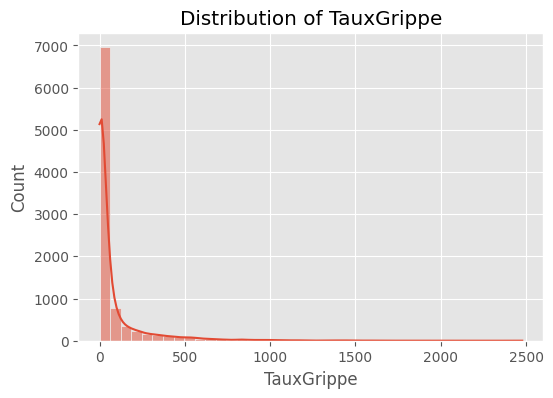

In [11]:
plt.figure(figsize=(6,4))
sns.histplot(df_train['TauxGrippe'], bins=40, kde=True)
plt.title('Distribution of TauxGrippe')
plt.show()

The target variable has a right-skewed distribution with a large number of low influenza rates. This pattern is a normal epidemiological behavior rather than outliers.

Most observations fall between 0 and 500, indicating low influenza activity for the majority of weeks and regions. 

The rare but extreme values represent epidemic outbreaks, not outliers but epidemy case - normal. We won't transform as efficient models like Random Forest & XGBoost work well with asymetry.

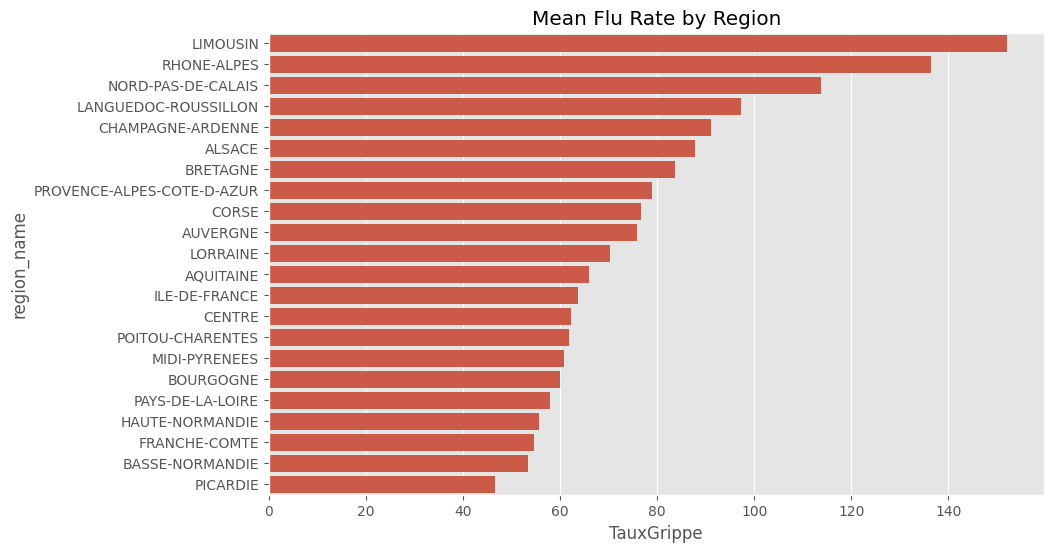

In [12]:
df_region = (
    df_train
    .groupby('region_name')['TauxGrippe']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_region,
    x='TauxGrippe',
    y='region_name'
)
plt.title('Mean Flu Rate by Region')
plt.show()

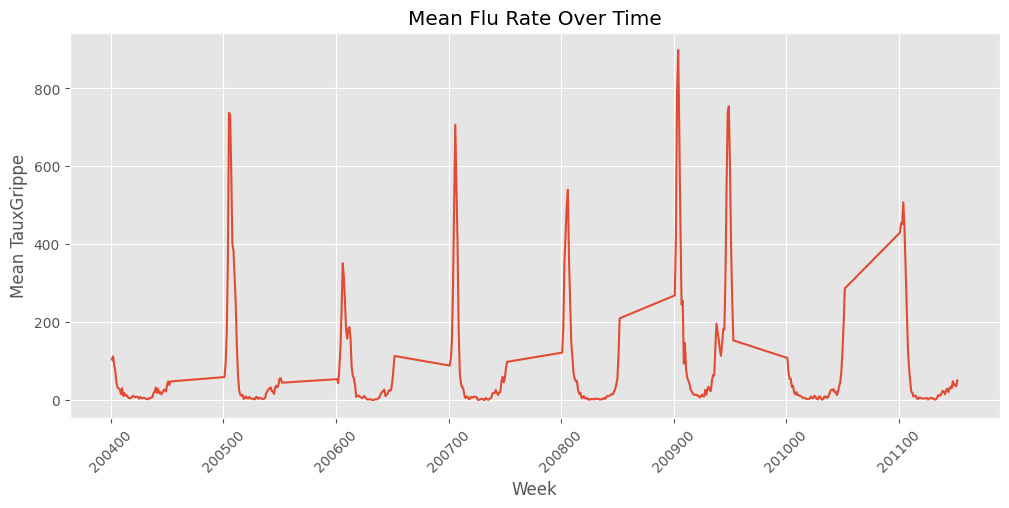

In [13]:
df_week = (
    df_train
    .groupby('week')['TauxGrippe']
    .mean()
    .reset_index()
)

plt.figure(figsize=(12, 5))
plt.plot(df_week['week'], df_week['TauxGrippe'])
plt.title('Mean Flu Rate Over Time')
plt.xlabel('Week')
plt.ylabel('Mean TauxGrippe')
plt.xticks(rotation=45)
plt.show()

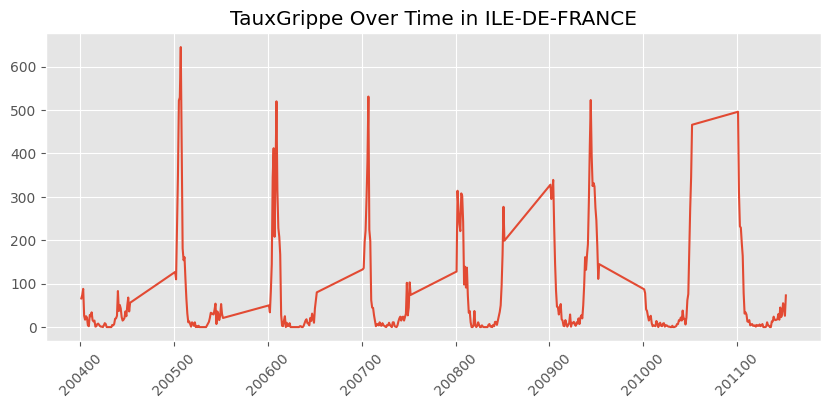

In [14]:
# flu rate over time for a specific region
df_one_region = df_train[df_train['region_name'] == 'ILE-DE-FRANCE']

plt.figure(figsize=(10,4))
plt.plot(df_one_region['week'], df_one_region['TauxGrippe'])
plt.title('TauxGrippe Over Time in ILE-DE-FRANCE')
plt.xticks(rotation=45)
plt.show()

## Outliers

In [15]:
# identify top 1% outliers in TauxGrippe
outliers = df_train[df_train['TauxGrippe'] > df_train['TauxGrippe'].quantile(0.99)]

print("Top 1% of values :", outliers[['region_name','week','TauxGrippe']])

Top 1% of values :              region_name    week  TauxGrippe
1064               CORSE  201104        1303
1068            LIMOUSIN  201104         980
1086               CORSE  201103         949
1115  NORD-PAS-DE-CALAIS  201102        1555
1137  NORD-PAS-DE-CALAIS  201101        1573
...                  ...     ...         ...
7933            LORRAINE  200505         936
7935  NORD-PAS-DE-CALAIS  200505        1656
7936    PAYS-DE-LA-LOIRE  200505        1689
7941         RHONE-ALPES  200505        1855
7963         RHONE-ALPES  200504         955

[92 rows x 3 columns]


## Extracting weeks & years

In [16]:
# Preparing data for merging with meteorological data
df_train['week'] = df_train['week'].astype(str)  
df_train['year'] = df_train['week'].str[:4].astype(int)       
df_train['week_num'] = df_train['week'].str[4:].astype(int)  

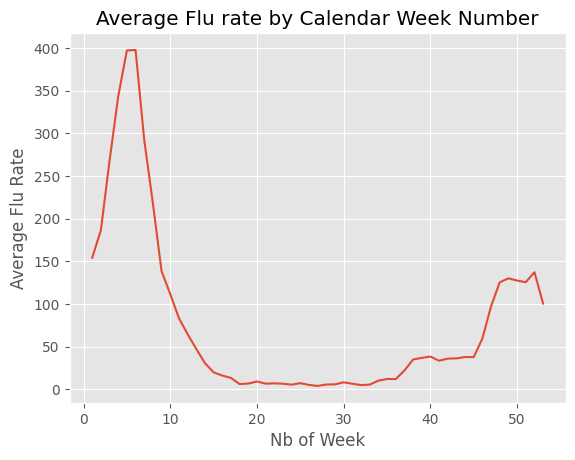

In [18]:
# Visualize average TauxGrippe by calendar week number
weekly_mean = df_train.groupby('week_num')['TauxGrippe'].mean()
plt.figure()
weekly_mean.plot()
plt.title('Average Flu rate by Calendar Week Number')
plt.xlabel('Nb of Week')
plt.ylabel('Average Flu Rate')
plt.show()

Seasonal peaks appear at the beginning & end of the year (around weeks 48–52 and weeks 1–12), corresponding to the winter period.

In the middle of the year (spring & summer), influenza activity is very low, with a clear trough and values close to zero.
These seasonal patterns are highly informative for the model, as they highlight strong seasonality in influenza dynamics.

In [26]:
df_train['year'].min(), df_train['year'].max()

(np.int64(2004), np.int64(2011))

It means that our train range is from 2004 to 2011, no particular need to merge 2012< data.

## Conclusion 
- no missing values
- 418 weeks & 22 regions
- slear seasonality with peaks in winter - logically right
- logical distribution with flu peaks in winter.

Globally & environmentally the data looks coherent.

# Meteo metadata prep

## Synop merge

In [22]:
DATA_DIR = Path("data/DonneesMeteorologiques/DonneesMeteorologiques")
files = sorted(DATA_DIR.glob("synop.*.csv"))

print("Nb of synop files :", len(files))

Nb of synop files : 154


In [24]:
dfs = []

for f in files:
    df = pd.read_csv(f, sep=";", low_memory=False)
    dfs.append(df)

df_synop_merged = pd.concat(dfs, ignore_index=True)

In [25]:
print('Synop Merged Dataframe',df_synop_merged.shape)
df_synop_merged.head()

Synop Merged Dataframe (2163605, 60)


,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4,Unnamed: 59
0,7005,20040101000000,102160,-350,8,170,5.100000,273.250000,272.250000,93,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
1,7015,20040101000000,102190,-290,8,160,3.100000,272.950000,271.950000,92,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
2,7020,20040101000000,101760,-380,6,180,13.900000,279.950000,275.450000,73,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
3,7027,20040101000000,102080,-370,6,170,5.100000,273.750000,272.850000,94,...,7,0,7500,mq,mq,mq,mq,mq,mq,NaN
4,7037,20040101000000,102240,-310,6,180,4.100000,272.750000,271.650000,91,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN


In [27]:
df_synop_merged['numer_sta'].nunique()

62

We have 62 OMM stations.

In [28]:
df_synop_merged.dtypes

numer_sta        int64
date             int64
pmer            object
tend            object
cod_tend        object
dd              object
ff              object
t               object
td              object
u               object
vv              object
ww              object
w1              object
w2              object
n               object
nbas            object
hbas            object
cl              object
cm              object
ch              object
pres            object
niv_bar         object
geop            object
tend24          object
tn12            object
tn24            object
tx12            object
tx24            object
tminsol         object
sw              object
tw              object
raf10           object
rafper          object
per             object
etat_sol        object
ht_neige        object
ssfrai          object
perssfrai       object
rr1             object
rr3             object
rr6             object
rr12            object
rr24            object
phenspe1   

## Missing Values Check

In [38]:
# check for missing values 
df_synop_merged.isna().sum()

numer_sta          0
date               0
pmer           87767
tend          358230
cod_tend      366203
dd             47356
ff             46422
t               5046
td             13480
u              14499
vv            582587
ww            608031
w1           1090839
w2           1109586
n             860486
nbas         1039523
hbas          957862
cl           1135226
cm           1158519
ch           1166054
pres          299633
niv_bar      2115810
geop         2104953
tend24       1726912
tn12         1699191
tn24         2123582
tx12         1694826
tx24         2128177
tminsol      1821582
sw           2163605
tw           2163605
raf10        1873622
rafper        437738
per           436393
etat_sol     1857352
ht_neige     1772834
ssfrai       1646083
perssfrai    1661505
rr1           499903
rr3           345903
rr6          1411633
rr12         1534916
rr24         1678424
phenspe1      683455
phenspe2      724476
phenspe3     1538639
phenspe4     2144457
nnuage1      

In [30]:
df_synop_merged = df_synop_merged.drop(columns=['Unnamed: 59'])

In [33]:
df_synop_merged = df_synop_merged.replace('mq', np.nan)

In [34]:
print(df_synop_merged.shape)
df_synop_merged.head()

(2163605, 59)


,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
0,7005,20040101000000,102160,-350,8,170,5.100000,273.250000,272.250000,93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7015,20040101000000,102190,-290,8,160,3.100000,272.950000,271.950000,92,...,630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7020,20040101000000,101760,-380,6,180,13.900000,279.950000,275.450000,73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7027,20040101000000,102080,-370,6,170,5.100000,273.750000,272.850000,94,...,3300,7,0,7500,NaN,NaN,NaN,NaN,NaN,NaN
4,7037,20040101000000,102240,-310,6,180,4.100000,272.750000,271.650000,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# check for missing values 
df_synop_merged.isna().sum()

numer_sta          0
date               0
pmer           87767
tend          358230
cod_tend      366203
dd             47356
ff             46422
t               5046
td             13480
u              14499
vv            582587
ww            608031
w1           1090839
w2           1109586
n             860486
nbas         1039523
hbas          957862
cl           1135226
cm           1158519
ch           1166054
pres          299633
niv_bar      2115810
geop         2104953
tend24       1726912
tn12         1699191
tn24         2123582
tx12         1694826
tx24         2128177
tminsol      1821582
sw           2163605
tw           2163605
raf10        1873622
rafper        437738
per           436393
etat_sol     1857352
ht_neige     1772834
ssfrai       1646083
perssfrai    1661505
rr1           499903
rr3           345903
rr6          1411633
rr12         1534916
rr24         1678424
phenspe1      683455
phenspe2      724476
phenspe3     1538639
phenspe4     2144457
nnuage1      

## Stations Import

In [35]:
df_stations = pd.read_csv('data/ListedesStationsMeteo.csv', sep=";")
df_stations.columns = ["ID", "Nom", "Latitude", "Longitude", "Altitude"]

In [36]:
print('Meteo Stations Dataframe', df_stations.shape)
df_stations.head()

Meteo Stations Dataframe (62, 5)


,ID,Nom,Latitude,Longitude,Altitude
0,7005,ABBEVILLE,50.136000,1.834000,69
1,7015,LILLE-LESQUIN,50.570000,3.097500,47
2,7020,PTE DE LA HAGUE,49.725167,-1.939833,6
3,7027,CAEN-CARPIQUET,49.180000,-0.456167,67
4,7037,ROUEN-BOOS,49.383000,1.181667,151


In [37]:
df_stations.dtypes

ID             int64
Nom           object
Latitude     float64
Longitude    float64
Altitude       int64
dtype: object

In [40]:
# check for missing values 
df_stations.isna().sum()

ID           0
Nom          0
Latitude     0
Longitude    0
Altitude     0
dtype: int64

## Meteo + Stations merge by station_id + coordonnées

In [42]:
df_meteo = df_synop_merged.merge(
    df_stations[["ID", "Nom", "Latitude", "Longitude", "Altitude"]],
    left_on="numer_sta",
    right_on="ID",
    how="left"
)

print("meteo shape:", df_meteo.shape)
print("Stations inconnues (Nom NaN) :", df_meteo["Nom"].isna().sum())
df_meteo[["numer_sta", "Nom", "Latitude", "Longitude"]].head()

meteo shape: (2163605, 64)
Stations inconnues (Nom NaN) : 0


,numer_sta,Nom,Latitude,Longitude
0,7005,ABBEVILLE,50.136000,1.834000
1,7015,LILLE-LESQUIN,50.570000,3.097500
2,7020,PTE DE LA HAGUE,49.725167,-1.939833
3,7027,CAEN-CARPIQUET,49.180000,-0.456167
4,7037,ROUEN-BOOS,49.383000,1.181667


## Converting synop data in datetime + year + week_num

In [43]:
df_meteo["date_dt"] = pd.to_datetime(df_meteo["date"].astype(str), format="%Y%m%d%H%M%S", errors="coerce")
print("Dates invalides:", df_meteo["date_dt"].isna().sum())

df_meteo["year"] = df_meteo["date_dt"].dt.year
df_meteo["week_num"] = df_meteo["date_dt"].dt.isocalendar().week.astype(int)
df_meteo[["date", "date_dt", "year", "week_num"]].head()


Dates invalides: 0


,date,date_dt,year,week_num
0,20040101000000,2004-01-01,2004,1
1,20040101000000,2004-01-01,2004,1
2,20040101000000,2004-01-01,2004,1
3,20040101000000,2004-01-01,2004,1
4,20040101000000,2004-01-01,2004,1


## Adding a region to weather stations (simple mapping)

In [44]:
df_stations["city"] = (
    df_stations["Nom"]
    .str.upper()
    .str.replace("-", " ", regex=False)
    .str.strip()
)
df_stations["city"].value_counts().head(15)

city
ABBEVILLE           1
GILLOT AEROPORT     1
ST GIRONS           1
TOULOUSE BLAGNAC    1
MONTPELLIER         1
MARIGNANE           1
CAP CEPET           1
NICE                1
PERPIGNAN           1
AJACCIO             1
BASTIA              1
GLORIEUSES          1
JUAN DE NOVA        1
EUROPA              1
TROMELIN            1
Name: count, dtype: int64

#### Progressive mapping

In [45]:
city_to_region = {
    "ABBEVILLE": "PICARDIE",
    "LILLE LESQUIN": "NORD-PAS-DE-CALAIS",
    "PTE DE LA HAGUE": "BASSE-NORMANDIE",
    "CAEN CARPIQUET": "BASSE-NORMANDIE",
    "ROUEN BOOS": "HAUTE-NORMANDIE",
    "REIMS PRUNAY": "CHAMPAGNE-ARDENNE",
    "BREST GUIPAVAS": "BRETAGNE",
    "PLOUMANAC H": "BRETAGNE",
    "RENNES ST JACQUES": "BRETAGNE",
    "ALENCON": "BASSE-NORMANDIE",
    "ORLY": "ILE-DE-FRANCE",
    "TROYES BARBEREY": "CHAMPAGNE-ARDENNE",
    "NANCY OCHEY": "LORRAINE",
    "STRASBOURG ENTZHEIM": "ALSACE",
    "BELLE ILE LE TALUT": "BRETAGNE",
    "NANTES BOUGUENAIS": "PAYS-DE-LA-LOIRE",
    "TOURS": "CENTRE",
    "BOURGES": "CENTRE",
    "DIJON LONGVIC": "BOURGOGNE",
    "POITIERS BIARD": "POITOU-CHARENTES",
    "BALE MULHOUSE": "ALSACE",
    "PTE DE CHASSIRON": "POITOU-CHARENTES",
}

In [46]:
df_stations["region_name"] = df_stations["city"].map(city_to_region)
print("Stations sans region :", df_stations["region_name"].isna().sum(), "/", len(df_stations))
df_stations[df_stations["region_name"].isna()][["Nom","city"]]

Stations sans region : 41 / 62


,Nom,city
7,PLOUMANAC'H,PLOUMANAC'H
22,LIMOGES-BELLEGARDE,LIMOGES BELLEGARDE
23,CLERMONT-FD,CLERMONT FD
24,LE PUY-LOUDES,LE PUY LOUDES
25,LYON-ST EXUPERY,LYON ST EXUPERY
26,BORDEAUX-MERIGNAC,BORDEAUX MERIGNAC
27,GOURDON,GOURDON
28,MILLAU,MILLAU
29,MONTELIMAR,MONTELIMAR
30,EMBRUN,EMBRUN


In [47]:
city_to_region.update({
    "PLOUMANAC H": "BRETAGNE",
    "LIMOGES BELLEGARDE": "LIMOUSIN",
    "CLERMONT FD": "AUVERGNE",
    "LE PUY LOUDES": "AUVERGNE",
    "LYON ST EXUPERY": "RHONE-ALPES",
    "BORDEAUX MERIGNAC": "AQUITAINE",
    "GOURDON": "MIDI-PYRENEES",
    "MILLAU": "MIDI-PYRENEES",
    "MONTELIMAR": "RHONE-ALPES",
    "EMBRUN": "PROVENCE-ALPES-COTE-D-AZUR",
    "MONT DE MARSAN": "AQUITAINE",
    "TARBES OSSUN": "MIDI-PYRENEES",
    "ST GIRONS": "MIDI-PYRENEES",
    "TOULOUSE BLAGNAC": "MIDI-PYRENEES",
    "MONTPELLIER": "LANGUEDOC-ROUSSILLON",
    "MARIGNANE": "PROVENCE-ALPES-COTE-D-AZUR",
    "CAP CEPET": "PROVENCE-ALPES-COTE-D-AZUR",
    "NICE": "PROVENCE-ALPES-COTE-D-AZUR",
    "PLOUMANAC H": "BRETAGNE",
    "PERPIGNAN": "LANGUEDOC-ROUSSILLON",
    "AJACCIO": "CORSE",
    "BASTIA": "CORSE",

    
    "GILLOT AEROPORT": "REUNION",
    "ST PIERRE": "REUNION",
    "PAMANDZI": "MAYOTTE",

   
    "LE RAIZET AERO": "GUADELOUPE",
    "LA DESIRADE METEO": "GUADELOUPE",
    "ST BARTHELEMY METEO": "SAINT-BARTHELEMY",
    "TRINITE CARAVEL": "MARTINIQUE",
    "LAMENTIN AERO": "MARTINIQUE",

    
    "CAYENNE MATOURY": "GUYANE",
    "SAINT LAURENT": "GUYANE",
    "SAINT GEORGES": "GUYANE",
    "MARIPASOULA": "GUYANE",

    
    "GLORIEUSES": "TAAF",
    "JUAN DE NOVA": "TAAF",
    "EUROPA": "TAAF",
    "TROMELIN": "TAAF",
    "NOUVELLE AMSTERDAM": "TAAF",
    "CROZET": "TAAF",
    "KERGUELEN": "TAAF",
    "DUMONT D URVILLE": "TAAF",
})


In [48]:
df_stations["region_name"] = df_stations["city"].map(city_to_region)

In [49]:
print("Stations with no region :", df_stations["region_name"].isna().sum(), "/", len(df_stations))
df_stations[df_stations["region_name"].isna()][["Nom","city"]]

Stations with no region : 2 / 62


,Nom,city
7,PLOUMANAC'H,PLOUMANAC'H
61,DUMONT D'URVILLE,DUMONT D'URVILLE


In [50]:
df_stations[df_stations["region_name"].notna()][["ID","Nom","city","region_name"]].head(20)

,ID,Nom,city,region_name
0,7005,ABBEVILLE,ABBEVILLE,PICARDIE
1,7015,LILLE-LESQUIN,LILLE LESQUIN,NORD-PAS-DE-CALAIS
2,7020,PTE DE LA HAGUE,PTE DE LA HAGUE,BASSE-NORMANDIE
3,7027,CAEN-CARPIQUET,CAEN CARPIQUET,BASSE-NORMANDIE
4,7037,ROUEN-BOOS,ROUEN BOOS,HAUTE-NORMANDIE
5,7072,REIMS-PRUNAY,REIMS PRUNAY,CHAMPAGNE-ARDENNE
6,7110,BREST-GUIPAVAS,BREST GUIPAVAS,BRETAGNE
8,7130,RENNES-ST JACQUES,RENNES ST JACQUES,BRETAGNE
9,7139,ALENCON,ALENCON,BASSE-NORMANDIE
10,7149,ORLY,ORLY,ILE-DE-FRANCE


In [51]:
stations_link = df_stations[["ID", "region_name"]].copy()
stations_link.head()

,ID,region_name
0,7005,PICARDIE
1,7015,NORD-PAS-DE-CALAIS
2,7020,BASSE-NORMANDIE
3,7027,BASSE-NORMANDIE
4,7037,HAUTE-NORMANDIE


In [52]:
meteo_region = df_synop_merged.merge(
    stations_link,
    left_on="numer_sta",
    right_on="ID",
    how="inner"   # keeping only known stations
)

meteo_region[["numer_sta", "region_name", "date"]].head()


,numer_sta,region_name,date
0,7005,PICARDIE,20040101000000
1,7015,NORD-PAS-DE-CALAIS,20040101000000
2,7020,BASSE-NORMANDIE,20040101000000
3,7027,BASSE-NORMANDIE,20040101000000
4,7037,HAUTE-NORMANDIE,20040101000000


In [53]:
meteo_region["date_dt"] = pd.to_datetime(
    meteo_region["date"].astype(str),
    format="%Y%m%d%H%M%S",
    errors="coerce"
)

meteo_region["year"] = meteo_region["date_dt"].dt.year
meteo_region["week_num"] = meteo_region["date_dt"].dt.isocalendar().week.astype(int)

meteo_region[["date", "date_dt", "year", "week_num"]].head()


,date,date_dt,year,week_num
0,20040101000000,2004-01-01,2004,1
1,20040101000000,2004-01-01,2004,1
2,20040101000000,2004-01-01,2004,1
3,20040101000000,2004-01-01,2004,1
4,20040101000000,2004-01-01,2004,1


In [54]:
features = ["t", "ff", "u", "pres", "rr"]
features = [c for c in features if c in meteo_region.columns]
print("Features utilisées:", features)

m = meteo_region[["region_name", "year", "week_num"] + features].copy()
m = m.dropna(subset=["region_name", "year", "week_num"])

# Forcing features to numeric (mq/text -> NaN)
for c in features:
    m[c] = pd.to_numeric(m[c], errors="coerce")

# Agrégation
agg = {c: "mean" for c in features}
if "rr" in agg:
    agg["rr"] = "sum"

meteo_weekly = (
    m.groupby(["region_name", "year", "week_num"], as_index=False)
     .agg(agg)
)

meteo_weekly.head()

Features utilisées: ['t', 'ff', 'u', 'pres']


,region_name,year,week_num,t,ff,u,pres
0,ALSACE,2004,1,270.450000,2.432812,86.625000,99184.687500
1,ALSACE,2004,2,276.984821,2.956250,87.455357,99129.196429
2,ALSACE,2004,3,279.228571,5.610714,81.383929,97999.196429
3,ALSACE,2004,4,273.860714,2.415179,83.107143,99185.000000
4,ALSACE,2004,5,275.210714,4.235714,78.428571,98483.035714


In [55]:
meteo_weekly.shape

(18344, 7)

In [56]:
meteo_weekly[["year","week_num"]].drop_duplicates().shape

(673, 2)

## Merge Train & Synop

In [ ]:
# create year and week_num in train
df_train["year"] = (df_train["week"] // 100).astype(int)
df_train["week_num"] = (df_train["week"] % 100).astype(int)

In [57]:
df_train_meteo= df_train.merge(
    meteo_weekly,
    on=["region_name", "year", "week_num"],
    how="left"
)

df_train_meteo.head(30)

,Id,week,region_code,region_name,TauxGrippe,year,week_num,t,ff,u,pres
0,5523,201152,42,ALSACE,66,2011,52,276.169531,2.717188,87.148438,100088.515625
1,5524,201152,72,AQUITAINE,24,2011,52,278.931890,2.639370,91.582677,102322.992126
2,5525,201152,83,AUVERGNE,91,2011,52,276.664844,2.418750,86.179688,95887.734375
3,5526,201152,25,BASSE-NORMANDIE,49,2011,52,279.930105,5.060000,87.575916,101798.324607
4,5527,201152,26,BOURGOGNE,33,2011,52,276.020312,2.901562,92.578125,100011.093750
5,5528,201152,53,BRETAGNE,50,2011,52,280.816667,4.765104,86.921875,102023.203125
6,5529,201152,24,CENTRE,30,2011,52,277.878906,3.278906,92.617188,101156.015625
7,5530,201152,21,CHAMPAGNE-ARDENNE,13,2011,52,277.409375,3.692188,89.468750,101297.031250
8,5531,201152,94,CORSE,19,2011,52,281.665625,2.752344,72.820312,102122.968750
9,5532,201152,43,FRANCHE-COMTE,20,2011,52,NaN,NaN,NaN,NaN


In [ ]:
# extract year from week column to see the range of years in the dataset
df_train['year'] = df_train['week'].astype(str).str[:4].astype(int)
df_train['year'].min(), df_train['year'].max()

(np.int64(2004), np.int64(2011))

In [58]:
df_train_meteo.shape

(9196, 11)

In [60]:
df_train_meteo.to_csv("train_meteo.csv", index=False)